In [1]:
import cv2
import numpy
import matplotlib.pyplot as plt
import math
import Lane_functions                              #Funciones utilizadas para encontrar posición de los carriles

Que pedo muchachos 

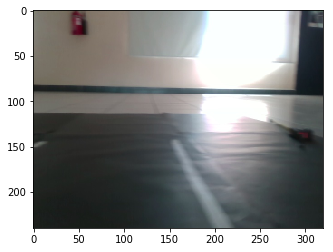

In [2]:
state = 1
cv_image = plt.imread('BE_Lane_data/Auditorio/left0060.jpg')   #En el V.E. se obtendrán imagenes de 320x240 para tener un
cv_image = cv2.resize(cv_image, (320,240))                 #procesamiento más rápido
plt.imshow(cv_image)  

In [3]:
#A partir de este punto se procesa la imagen para obtener una imagen binaria con solo el fondo y los bordes.
#Los bordes nos interesan porque algunos de ellos representan los carriles

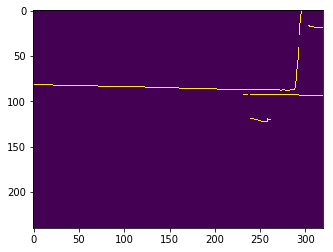

In [4]:
gray = cv2.cvtColor(cv_image,cv2.COLOR_BGR2GRAY)

kernelSize = 5
blur1 = cv2.GaussianBlur(gray,(kernelSize,kernelSize),0) #Eliminar Ruido

minThreshold = 120
maxThreshold = 200
edge = cv2.Canny(blur1,minThreshold,maxThreshold) #Detectar esquinas  
plt.imshow(edge)  

In [5]:
#La imagen previa se "suaviza" utilizando otro GaussianBlur para darle continuidad a los pixeles de los bordes

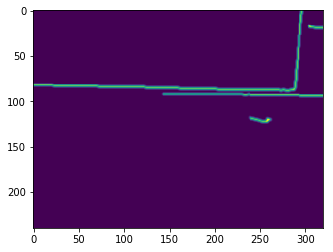

In [6]:
blur2 = cv2.GaussianBlur(edge,(kernelSize,kernelSize),0) #Eliminar Ruido
plt.imshow(blur2)

In [7]:
#No es necesario procesar toda la imagen porque se sabe que los carriles deben
#aparecer sólo en la mitad inferior de la misma. 
#Para esto se establece una región de interes. 


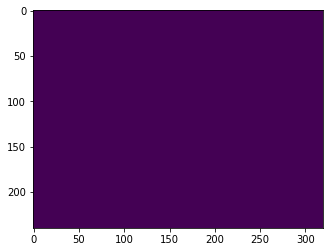

In [8]:
#Establecer el las esquinas del rectangulo considerado como ROI
lowerLeftPoint = [0, 240]
upperLeftPoint = [0,160]
upperRightPoint = [320,160]
lowerRightPoint = [320,240]

pts = numpy.array([[lowerLeftPoint,upperLeftPoint,upperRightPoint,lowerRightPoint]], dtype=numpy.int32)

#Función para obtener la región de interes
masked_image = Lane_functions.region_of_interest(blur2,pts)
plt.imshow(masked_image)

In [9]:
#Para tener una e procede a encontrar una vista aerea de la imagen. 

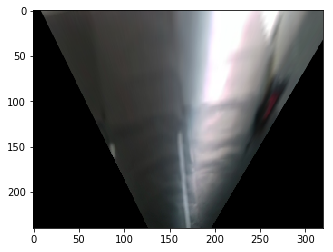

In [10]:
pts1 = numpy.float32([[110,130],[195,132],[294,240],[15,240]])  #puntos obtenidos apartir de imagen prueba junto con mediciones
pts3 = numpy.float32([[130,95],[190,95],[190,240],[130,240]])
M_n = cv2.getPerspectiveTransform(pts1,pts3)

binary_warped = cv2.warpPerspective(masked_image,M_n,(320,240))  #Transformar la imagen a vista de ave, cada pixel corresponde a .25cm aprox

orig_warped = cv2.warpPerspective(cv_image,M_n,(320,240))
plt.imshow(orig_warped)

orig_warped = cv2.warpPerspective(cv_image,M_n,(320,240))
out_img = numpy.dstack((binary_warped, binary_warped, binary_warped))*255


In [11]:
lane1, lane2 = Lane_functions.image_lanes(binary_warped)

[]
[]


In [12]:
if   ((lane1 != []) and (lane2 != [])):
	state = 1
elif ((lane1 != []) and (lane2 == []) and (state==1) and (numpy.mean(lane1)>160)):
	state = 2
elif ((lane1 != []) and (lane2 == []) and (state==1) and (numpy.mean(lane1)<160)):
	state = 3
elif ((lane1 != []) and (lane2 == []) and (state==2) ):
	state = 2
elif ((lane1 != []) and (lane2 == []) and (state==3) ):
	state = 3
elif ((lane1 == []) and (lane2 == [])):
	state = 4
    
print(state)

4


In [13]:
if state == 1:
	#Utilizar los dos carriles para detectar error lateral
	left_fit = Lane_functions.poly_for_lane(lane1,out_img)
	right_fit = Lane_functions.poly_for_lane(lane2,out_img)
	
	ploty = numpy.linspace(0,binary_warped.shape[0]-1, binary_warped.shape[0])
	left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
	right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
	
	
	center_fit = Lane_functions.center_lane_f2(right_fitx,left_fitx,ploty)

	center_fitx = center_fit[0]*ploty**2+center_fit[1]*ploty+center_fit[2]


	plt.imshow(orig_warped)
	plt.plot(left_fitx, ploty, color='green')
	plt.plot(right_fitx, ploty, color='green')
	plt.plot(center_fitx, ploty, color='yellow')
	plt.xlim(0,320)
	plt.ylim(240,160)
	plt.show()


	
elif state == 2:
	#Utilizar un carril para detectar error lateral
	poly_fit = Lane_functions.poly_for_lane(lane1,out_img)
	ploty = numpy.linspace(0,binary_warped.shape[0]-1, binary_warped.shape[0])
	poly_fitx = poly_fit[0]*ploty**2+poly_fit[1]*ploty+poly_fit[2]

	center_fit =Lane_functions.center_lane_f1(poly_fitx,ploty,state)	
	center_fitx = center_fit[0]*ploty**2+center_fit[1]*ploty+center_fit[2]

	plt.imshow(orig_warped)
	plt.plot(poly_fitx, ploty, color='green')
	plt.plot(center_fitx, ploty, color='yellow')
	plt.xlim(0,320)
	plt.ylim(240,160)
	plt.show()
	
elif state == 3:
	#Utilizar un carril para detectar error lateral
	poly_fit = Lane_functions.poly_for_lane(lane1,out_img)
	ploty = np.linspace(0,binary_warped.shape[0]-1, binary_warped.shape[0])
	poly_fitx = poly_fit[0]*ploty**2+poly_fit[1]*ploty+poly_fit[2]

	center_fit = Lane_functions.center_lane_f1(poly_fitx,ploty,state)	
	center_fitx = center_fit[0]*ploty**2+center_fit[1]*ploty+center_fit[2]

	plt.imshow(orig_warped)
	plt.plot(poly_fitx, ploty, color='green')
	plt.plot(center_fitx, ploty, color='yellow')
	plt.xlim(0,320)
	plt.ylim(240,160)
	plt.show()

elif state == 4:
    print('no veo nada')

no veo nada
